In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import yaml
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, AutoEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from dwave_networkx.algorithms.coloring import min_vertex_color, is_vertex_coloring
import time
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
from graphilp.partitioning import min_vertex_coloring as vtx
from graphilp.imports import networkx as imp_nx

In [2]:
#q_sampler = AutoEmbeddingComposite(DWaveSampler(token='DEV-076b8a03c140ad9291e859ef02ab3403afc91429'))

#### Generate Network

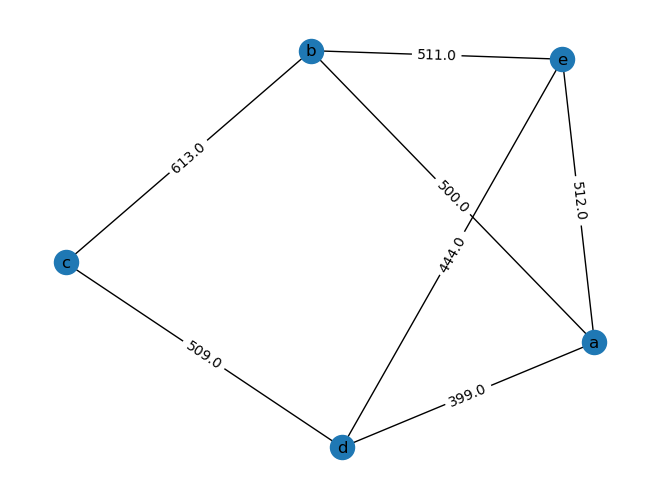

In [2]:
def plot_graph(filename):

    G = nx.read_weighted_edgelist(filename)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()
    return G
G=plot_graph("networks/LargerNetwork2.txt")


#### Generate Demands

In [4]:
def generate_demands(G):
    demands = {}
    for a in G.nodes:
        for b in G.nodes:
            if b == a:
                pass
            else:
                x = random.randrange(0, 3, 1)
                if x == 0:
                    demands[(a, b)] = 10
                elif x == 1:
                    demands[(a, b)] = 40
                else:
                    demands[(a, b)] = 100
    return demands
demands=generate_demands(G)



In [ ]:
# Cropped demands only show demands for 1 direction
cropped_demands={}
for item in demands:
    if item[1]>item[0]:
        cropped_demands[item]=demands[item]
print(cropped_demands)

#### Generate graph of routes

46
427


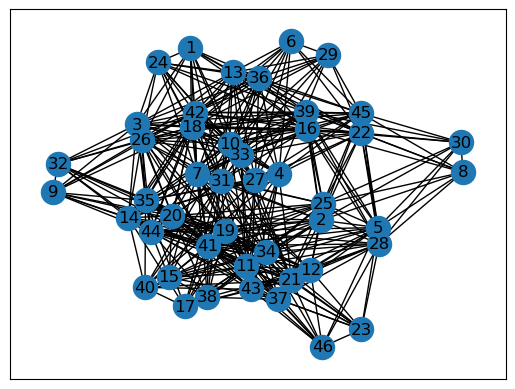

In [5]:
def create_graph(filepath, Graph, demands):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    converted_graph = nx.Graph()
    s_d_label = 0
    label = 0
    for a in network_data:
        s_d_label += 1
        source = network_data[a]["source"]
        destination = network_data[a]["destination"]
        rate = demands[(source, destination)]
        for i in network_data[a]["routes"]:
            label += 1
            nodes_in_path = i
            edges_in_path = []
            total_weight = 0
            for j in range(len(i) - 1):
                edges_in_path.append((nodes_in_path[j], nodes_in_path[j + 1]))
                edges_in_path.append((nodes_in_path[j+1], nodes_in_path[j])) # remove if direction of light matters.
                total_weight += Graph[nodes_in_path[j]][nodes_in_path[j + 1]]["weight"]
            converted_graph.add_node(label, s_d=s_d_label, r=rate,w=total_weight,edges=edges_in_path)
    x=converted_graph.number_of_nodes()
    for a in range(1,x):
        for b in range(a+1,x+1):
            if converted_graph.nodes[a]["s_d"] != converted_graph.nodes[b]["s_d"]: # don't want connection between same routes- then each one affects the others selection
                for j in converted_graph.nodes[a]["edges"]:
                    for i in converted_graph.nodes[b]["edges"]:
                        if i == j:
                            converted_graph.add_edge(a,b)
                            break
                    else:
                        continue
                    break
                        
                        
    return converted_graph

new_graph=create_graph("networks/LargerNetwork2-conversion.yaml",G,demands)
nx.draw_networkx(new_graph)
number_of_nodes=len(new_graph.nodes)
print(number_of_nodes)
print(new_graph.number_of_edges())


#### Write QUBO formulation

In [9]:
def create_qubo(Graph,c1,c2,c3,c4):
    Q={}
    adj_matrix=nx.adjacency_matrix(Graph)
    dense_matrix=adj_matrix.todense()
    set_of_nodes=Graph._node
    for a in set_of_nodes:
        for b in set_of_nodes:
            if Graph.nodes[a]["s_d"]==Graph.nodes[b]["s_d"]:
                if a==b:
                    Q[(a,b)]=-c1
                else:
                    Q[(a,b)]=2*c1
            elif dense_matrix[a-1][b-1]==1:
                Q[(a,b)]=c2
            else:
                Q[(a,b)]=0
    
    for a in set_of_nodes:
        length=Graph.nodes[a]["w"]
        Q[(a,a)]+=c4*length    
        if Graph.nodes[a]["r"]==10:
            max_d=1680
            if length>max_d:
                Q[(a,a)]+=c3
        else:
            neighbours=list(Graph.neighbors(a))
            affecting_neighbours=[]
            for i in neighbours:
                if Graph.nodes[i]["r"]==10:
                    affecting_neighbours.append(i)
            
            if Graph.nodes[a]["r"]==40:
                max_d=1301
                penalty=131
            elif Graph.nodes[a]["r"]==100:
                max_d=1430
                penalty=370
            
            if length>max_d:
                Q[(a,a)]+=c3
            elif length>(max_d-penalty):
                for i in affecting_neighbours:
                    Q[(a,i)]+=c3

    return Q
            
QUBO = create_qubo(new_graph,1,0.0,1,0)


bqm= BinaryQuadraticModel.from_qubo(QUBO)

#### Solve QUBO QA/SA

In [10]:
def solve_qubo(bqm,sampler=SimulatedAnnealingSampler(),num_runs=1):
    sampleset= sampler.sample(bqm,num_reads=num_runs,label= "Routing QUBO solving")
    return sampleset

result=solve_qubo(bqm)
print(result)


   1  2  3  4  5  6  7  8  9 10 11 12 energy num_oc.
0  1  0  0  1  0  1  1  0  0  1  1  0   -6.0       1
['BINARY', 1 rows, 1 samples, 12 variables]


#### Solve with Gurobi

In [16]:
def solve_qubo_with_gurobi(Q,time_limit=1000):
    # Create a Gurobi model
    model = Model("QUBO")

    # Suppress Gurobi output
    model.setParam('OutputFlag', 0)
    
    # Set a time limit (in seconds)
    model.setParam('TimeLimit', time_limit)

    # Extract variables from QUBO keys
    variables = set(i for i, j in Q.keys()).union(set(j for i, j in Q.keys()))

    # Add binary variables to the model
    x = {v: model.addVar(vtype=GRB.BINARY, name=f'x_{v}') for v in variables}

    # Add the QUBO objective function
    model.setObjective(
        quicksum(Q[i, j] * x[i] * x[j] for i, j in Q.keys()),
        GRB.MINIMIZE
    )
    # Measure the runtime
    start_time = time.time()
    model.optimize()
    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time


    # Extract the solution
    if model.status == GRB.OPTIMAL:
        solution = {v: int(x[v].x) for v in variables}
        objective_value = model.objVal
        return solution, objective_value,runtime
    else:
        return None, None

QUBO = create_qubo(new_graph,4.5,0.17,4.5,0.0003)

gurobi_sol=solve_qubo_with_gurobi(QUBO)
print(gurobi_sol)

Set parameter Username
Set parameter LicenseID to value 2690074
Academic license - for non-commercial use only - expires 2026-07-22
({1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0}, -23.780800000000003, 0.03731131553649902)


In [17]:
gurobi_table=[]
# Produce Gurobi output as a list
for i in range(1,number_of_nodes+1):
    gurobi_table.append(gurobi_sol[0][i])
print(gurobi_table)

[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]


#### Check if solution is valid

In [12]:
# Note that this function is not the same as is_valid_solution function in the other notebooks as it 
def is_valid_solution(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=[]
    total_length=0
    for i in Graph.nodes:
        solution_results.append(int(result.first.sample[i]))
        if int(result.first.sample[i])==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                neighbours=list(Graph.neighbors(i))
                affecting_neighbours=[]
                for j in neighbours:
                    if Graph.nodes[j]["r"]==10:
                        affecting_neighbours.append(j)        
                if Graph.nodes[i]["r"]==40:
                    if Graph.nodes[i]["w"] >1301:
                        return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    elif 1301 >= Graph.nodes[i]["w"] >1170:
                        for a in affecting_neighbours:
                            if int(result.first.sample[a])==1:
                                return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"],a]
                else:
                    if Graph.nodes[i]["w"] >1430:
                        return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    elif 1430 >= Graph.nodes[i]["w"] >1060:
                        for a in affecting_neighbours:
                            if int(result.first.sample[a])==1:
                                return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"],a]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]

print(is_valid_solution(result,"networks/graph2-conversion.yaml",new_graph))


[True, 5064.0]


#### Is solution same as Gurobi solution

In [18]:
solution_values=[]
for variable in range(1,number_of_nodes+1):
    solution_values.append(int(result.first.sample[variable]))
print(solution_values==gurobi_table)
for variable in range(1,number_of_nodes+1):
    if not solution_values[variable-1]==gurobi_table[variable-1]:
        print(variable)

True


#### Brute Force Parameter Search

#### Generate Reduced Graph

6


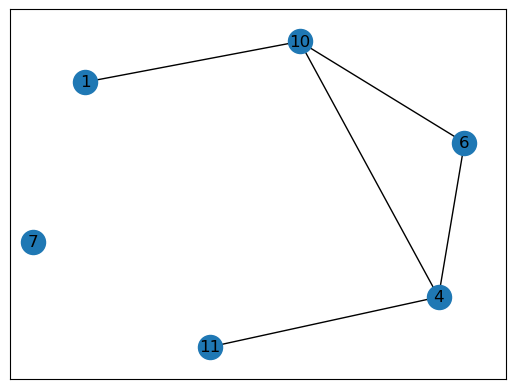

In [39]:
reduced_graph=create_graph("networks/graph2-conversion.yaml",G,demands)
for i in range(number_of_nodes):
    if solution_values[i]==0:
        reduced_graph.remove_node(i+1)

pos = nx.spring_layout(reduced_graph, k=100, iterations=100)
nx.draw_networkx(reduced_graph,pos=pos)
print(reduced_graph.number_of_nodes())

#### Gurobi Colouring

In [20]:
def solve_graph_coloring_gurobi(Graph):
    edges = list(Graph.edges)
    G = imp_nx.read(Graph)
    # List of edges (each edge represented as a tuple of nodes)
    

    # Create a Gurobi environment with output suppressed
    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)  # Suppress output
    env.start()
    
    # Create the model using vtx.create_model
    mdl = vtx.create_model(G)

    # Optimize the model
    start_time = time.time()
    mdl.optimize()
    end_time = time.time()

    # Extract the solution using the provided function
    color_to_node, node_to_color = vtx.extract_solution(G, mdl)

    if mdl.status == GRB.OPTIMAL:
        # Use the extracted solution to build the color_map
        color_map = {node: color for color, nodes in color_to_node.items() for node in nodes}
        used_colors = set(color_map.values())

        # Verify that no two adjacent nodes have the same color
        valid = True
        for (i, j) in edges:
            if color_map[i] == color_map[j]:
                valid = False
                break  # No need to continue if an invalid pair is found

        return {
            "valid": valid,
            "num_colors": len(used_colors),
            "time_taken": end_time - start_time
        }
    else:
        return {
            "valid": False,
            "num_colors": None,
            "time_taken": end_time - start_time
        }

#### LDF Greedy Colouring 

In [21]:
def solve_graph_coloring_networkx(G):
    start_time = time.time()
    nx_coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    end_time = time.time()

    nx_colors_used = len(set(nx_coloring.values()))

    return {
        "valid": True,  # Greedy algorithm should provide a valid coloring
        "num_colors": nx_colors_used,
        "time_taken": end_time - start_time,
        "coloring": nx_coloring
    }
 
colouring=solve_graph_coloring_networkx(reduced_graph)
print(colouring)

{'valid': True, 'num_colors': 3, 'time_taken': 0.0029249191284179688, 'coloring': {4: 0, 10: 1, 6: 2, 1: 0, 11: 1, 7: 0}}


#### SA/QA for colouring

In [22]:
def solve_graph_coloring_annealing(G, sampler, attempts=30):
    start_time = time.time()
    for i in range(attempts):        
        solution = min_vertex_color(G, sampler=sampler, label="GCP")
        try:
            if is_vertex_coloring(G, solution):
                end_time = time.time()
                wavelengths = len(set(solution.values()))
                return {
                    "valid": True,
                    "num_colors": wavelengths,
                    "time_taken": end_time - start_time,
                    "solution": solution
                }
            print(f"[-] Attempt {i} failed")
        except KeyError:
            continue
    return "timeout"
colouring=solve_graph_coloring_annealing(reduced_graph,SimulatedAnnealingSampler())
print(colouring)

{'valid': True, 'num_colors': 3, 'time_taken': 1.3023359775543213, 'solution': {1: 0, 4: 0, 6: 1, 7: 0, 10: 2, 11: 2}}


#### Generate Colouring

3


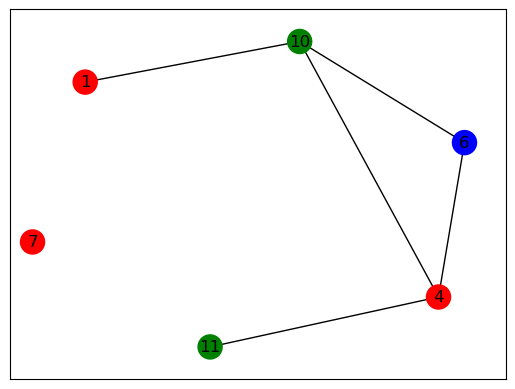

In [40]:
selected_colours=colouring["solution"]
colours = [
    "red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan",
    "magenta", "teal", "gold", "navy", "lime", "maroon", "coral", "turquoise", "indigo", "salmon",
    "darkgreen", "deepskyblue", "chocolate", "orchid", "slateblue", "darkorange", "skyblue", "firebrick", "mediumseagreen", "dodgerblue",
    "plum", "lightcoral", "mediumvioletred", "sienna", "khaki", "darkcyan", "steelblue", "crimson", "darkorchid", "mediumturquoise"
]
color_map=[]
for a in selected_colours:
    color_map.append(colours[selected_colours[a]])
print(colouring["num_colors"])
nx.draw_networkx(reduced_graph,node_color=color_map,pos=pos)

#### Brute Force Parameter Search

In [ ]:
solve_rate=[]
min_colouring=[]
total_lengths=[]
for i in range(0,50):
    QUBO = create_qubo(new_graph,4,0.001*i,10,0.0001)
    bqm= BinaryQuadraticModel.from_qubo(QUBO)
    #correct_solution=gurobi_table
    runs=3
    solved_cases=0
    time_taken=0
    colour_dic_SA={}
    for i in range(runs):
        start=time.perf_counter()
        solution=solve_qubo(bqm)
        end=time.perf_counter()
        time_taken+=(end-start)
        solution_outcomes=[]
        for variable in range(1,number_of_nodes+1):
            solution_outcomes.append(solution.first.sample[variable])
        if is_valid_solution(solution,"networks/poland-conversion2.yaml",new_graph)[0]:
            solved_cases+=1
            graph=new_graph.copy()
            total_length=0
            for i in range(number_of_nodes-1):
                if solution_outcomes[i]==0:
                    graph.remove_node(i+1)
                else:
                    total_length+=new_graph.nodes[i+1]["w"]
            coloured=solve_graph_coloring_networkx(graph)
            if coloured["num_colors"] in colour_dic_SA:
                colour_dic_SA[coloured["num_colors"]]+=1
            else:
                colour_dic_SA[coloured["num_colors"]]=1
            total_lengths.append(total_length)
    solve_rate.append(solved_cases/runs)
    if colour_dic_SA=={}:
        min_colouring.append(500)
    else:
        min_colouring.append(min(colour_dic_SA.keys()))
    

print(solve_rate)
print(min_colouring)
print(total_lengths)

#### SA accuracy check

In [26]:
QUBO = create_qubo(new_graph,1,0.009,1,0)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
runs=200
solved_cases=0
time_taken=0
optimal_solves=0
colour_dic_SA={}
colour_dic_lengths_SA={}
best_solution=None
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if is_valid_solution(solution,"networks/poland-conversion2.yaml",new_graph)[0]:
        solved_cases+=1
        graph=new_graph.copy()
        total_length=0
        for k in range(number_of_nodes-1):
            if solution_outcomes[k]==0:
                graph.remove_node(k+1)
            else:
                total_length+=new_graph.nodes[k+1]["w"]
        coloured=solve_graph_coloring_networkx(graph)
        if best_solution is None:
            best_solution=[coloured,total_length,solution]
        elif coloured["num_colors"] < best_solution[0]["num_colors"]:
            best_solution=[coloured,total_length,solution]
        elif coloured["num_colors"] == best_solution[0]["num_colors"]:
            if total_length < best_solution[1]:
                best_solution=[coloured,total_length,solution]
        if coloured["num_colors"] in colour_dic_lengths_SA:
            colour_dic_lengths_SA[coloured["num_colors"]].append(total_length)
        else:
            colour_dic_lengths_SA[coloured["num_colors"]]=[total_length]
        if coloured["num_colors"] in colour_dic_SA:
            colour_dic_SA[coloured["num_colors"]]+=1
        else:
            colour_dic_SA[coloured["num_colors"]]=1
    

print(solved_cases/runs,time_taken/runs,colour_dic_SA) 
print(best_solution[0]["num_colors"],best_solution[1],best_solution[2])

0.67 1.58690509750013 {26: 35, 25: 41, 24: 23, 27: 29, 29: 1, 28: 3, 23: 2}
23 56142.599999999984    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 ... 924  energy num_oc.
0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 ...   0 -95.316       1
['BINARY', 1 rows, 1 samples, 924 variables]


#### Is new solution unique to this formulation

In [ ]:
# Unique to this formulation, to detect if it is solutions found could not be found by the Worst Case QUBO formulation
def is_valid_solution_other(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=[]
    total_length=0
    for i in Graph.nodes:
        solution_results.append(int(result.first.sample[i]))
        if int(result.first.sample[i])==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]
specific_to_this_case=0
when=[]
for i in range(0,20):
    QUBO = create_qubo(new_graph,1,0,3.5,0,)
    bqm= BinaryQuadraticModel.from_qubo(QUBO)
    solution=solve_qubo(bqm)
    if not is_valid_solution_other(solution,"networks/graph2-conversion.yaml",new_graph)[0]:
            specific_to_this_case+=1
            when.append(i)

print(specific_to_this_case,when)
    

0 []
